# Loading Data via Generators

## Creating Generators

In [1]:
# define file paths to relevant data
trainingDataPath = "../behavioral_cloning_data/"
csvFilePath = trainingDataPath + "driving_log.csv"
imagesPath = trainingDataPath + "IMG/"

In [2]:
import numpy as np
from helper import plotImages
from generators import createGenerators
from keras.preprocessing.image import ImageDataGenerator

# create closure to help with debugging and visualizations
def generatorClosure(csvFilePath, imagesPath):
    def inner_func(data_gen_pp, count=3, title="", prepreprocessing=lambda x, y: (x, y), undo=lambda x: x):
        '''
            data_gen_pp       -> a keras.preprocessing.image.ImageDataGenerator object to be used with training data
            count             -> how much of the training data to use for this generator
            prepreprocessing  -> a function meant to run on the training x, y data before any preprocessing
            undo              -> a function to assist w/ visualization and undoing logic that would render an 
                                 image as unrecognizable when plotted (mostly to undo normalization)
        '''
        # create training set and validation set data generators
        train_generator, validation_generator, t_len, v_len = createGenerators(csvFilePath=csvFilePath, 
                                                                             imagesPath=imagesPath, 
                                                                             data_gen_pp=data_gen_pp,
                                                                             prepreprocessing=prepreprocessing,
                                                                             subsegment=count)
        
        generated_images = []
        for i in range(count):
            data = next(train_generator)
            generated_images.append(undo(np.array(data[0])[0]).astype('uint8'))
            
        plotImages(images=generated_images, titles=[title for i in range(count)], columns=3)
                                    
    return inner_func

# use the closure that was just defined
plotGenerator = generatorClosure(csvFilePath, imagesPath)

Using TensorFlow backend.


## Preprocessing Visualizations

In the next several cells, we will be visualizing what effects different preprocessing methods have on the input images

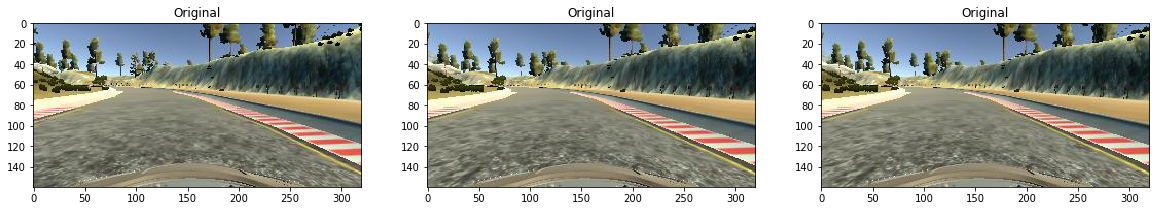

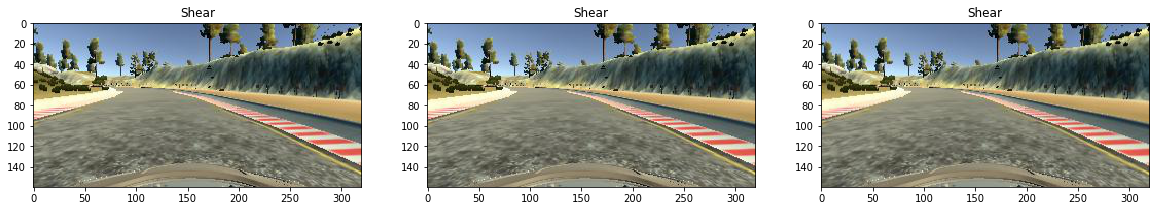

In [3]:
dataGenParams = {
    "rotation_range": 7,   
    "shear_range": 0.1,    
    "zoom_range": 0.2                                     
}

plotGenerator(ImageDataGenerator(), title="Original")
plotGenerator(ImageDataGenerator(rotation_range=dataGenParams["rotation_range"]), title="Rotation")
plotGenerator(ImageDataGenerator(shear_range=dataGenParams["shear_range"]), title="Shear")
plotGenerator(ImageDataGenerator(zoom_range=dataGenParams["zoom_range"]), title="Zoom")

### Testing Different Preprocessing and Pre-Preprocessing Methods

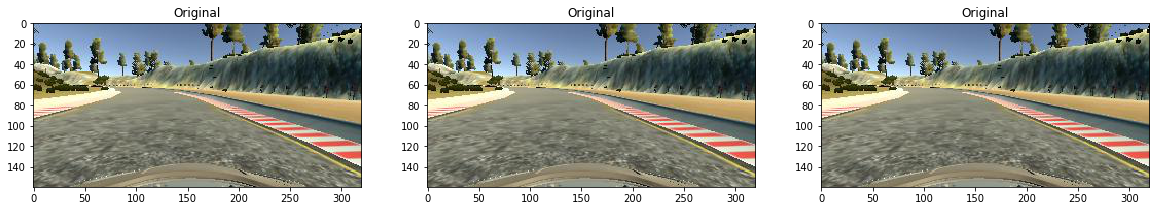

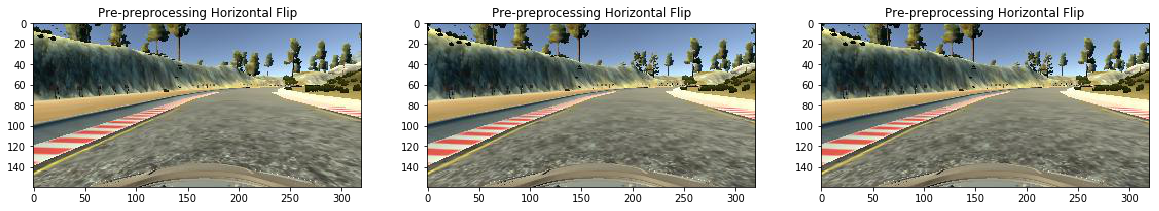

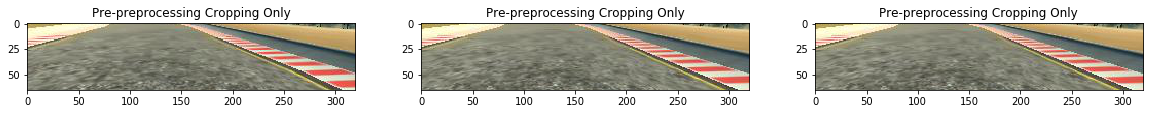

In [4]:
import cv2
from random import random

# normalize and zero mean center
def normalize(x):
    return x/127.5 - 1.    

def denormalize(x):
    return (x + 1.)*127.5

def crop(x, y):
    h, w, c = x.shape
    return x[70:h-25,0:w], y

def crop_no_label(x):
    return crop(x, 0)[0]

def horizontal_flip(x, y):
    '''
    x   -> the numpy multi-dimensional array image
    y   -> the float representing the steering angle
    '''
    return cv2.flip(x, 1), -1*y

def rand_horizontal_flip(x, y):
    '''
    x   -> the numpy multi-dimensional array image
    y   -> the float representing the steering angle
    
    Note: randomly flips the input half of the time
    '''
    # randomly flip
    if random() < 0.5:
        return horizontal_flip(x, y)
    else:
        return x, y

plotGenerator(ImageDataGenerator(), title="Original")
plotGenerator(ImageDataGenerator(), title="Pre-preprocessing Horizontal Flip", prepreprocessing=rand_horizontal_flip)
plotGenerator(ImageDataGenerator(), title="Pre-preprocessing Cropping Only", prepreprocessing=crop)

dataGenPrePreprocessing = rand_horizontal_flip

### Combining Preprocessing Methods

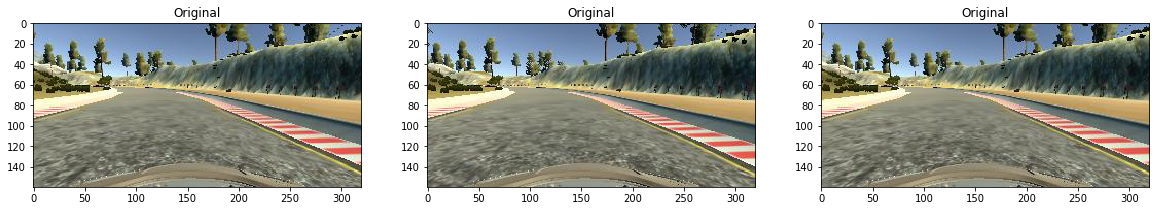

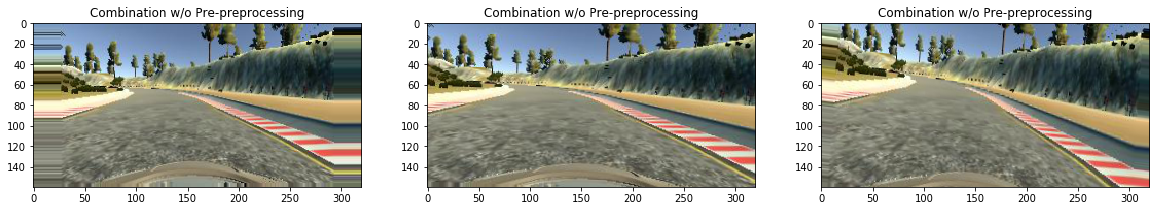

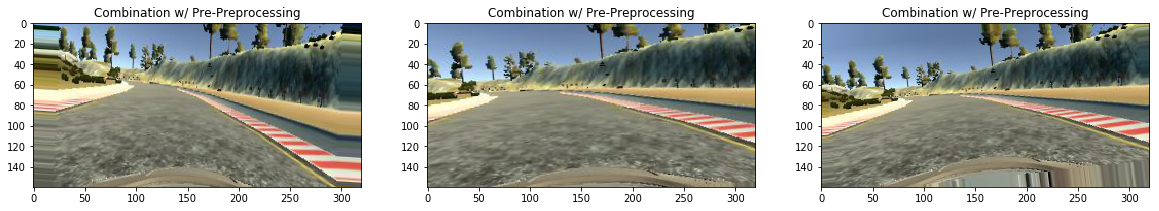

In [5]:
# drop fill_mode if there is one (can't assign the same value twice!)
dataGenParams.pop('fill_mode', None)

plotGenerator(ImageDataGenerator(), title="Original")
plotGenerator(ImageDataGenerator(**dataGenParams, fill_mode="nearest"), 
              title="Combination w/o Pre-preprocessing")

plotGenerator(ImageDataGenerator(**dataGenParams, fill_mode="nearest"), 
              title="Combination w/ Pre-Preprocessing",
              prepreprocessing=dataGenPrePreprocessing)

### Testing Different Fill Modes

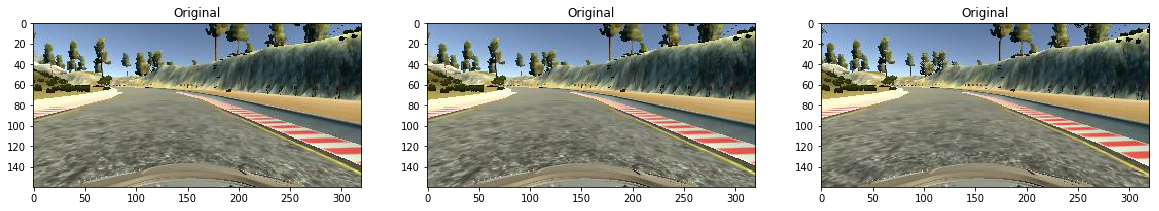

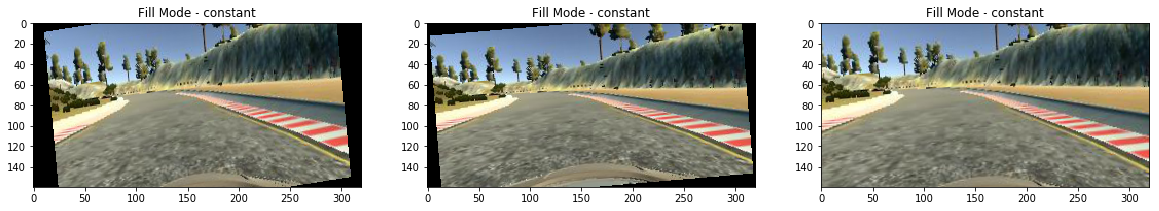

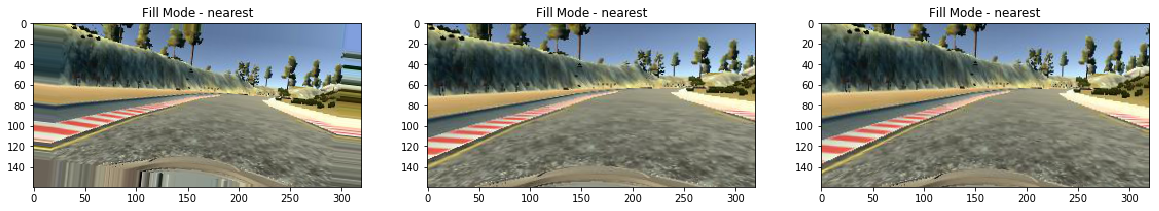

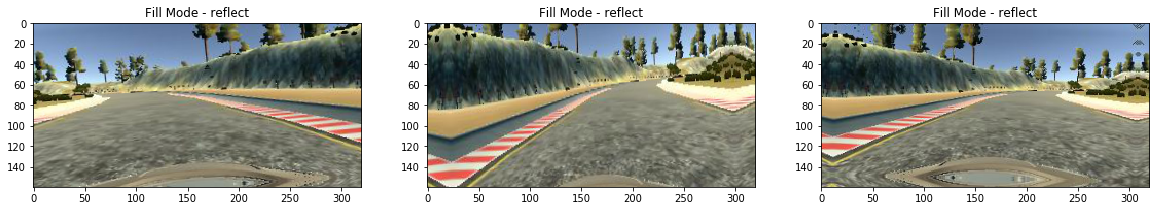

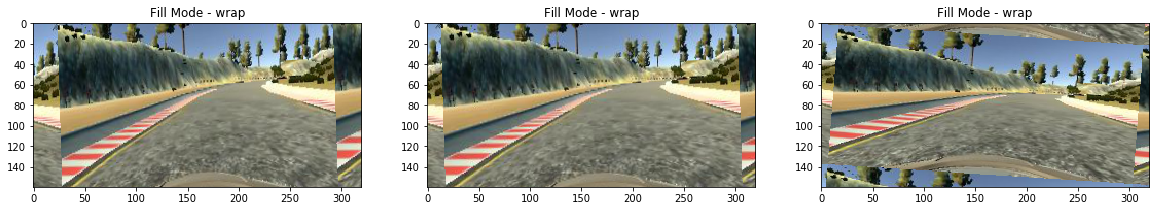

In [6]:
plotGenerator(ImageDataGenerator(), title="Original")

# drop fill_mode if there is one (can't assign the same value twice!)
dataGenParams.pop('fill_mode', None)

for fill_mode in ["constant", "nearest", "reflect", "wrap"]:
    plotGenerator(ImageDataGenerator(**dataGenParams, fill_mode=fill_mode), 
                  title="Fill Mode - " + fill_mode,
                  prepreprocessing=dataGenPrePreprocessing)

# assign what looks the best
dataGenParams["fill_mode"] = "nearest"

### Chosen Parameters for ImageDataGenerator

In [7]:
dataGenParams.pop("preprocessing_function", None)
print(dataGenParams)

{'fill_mode': 'nearest', 'zoom_range': 0.2, 'rotation_range': 7, 'shear_range': 0.1}


## Training The Model

In [131]:
from generators import createGenerators
from keras.preprocessing.image import ImageDataGenerator

# create training set and validation set data generators
batch_size = 32
train_generator, validation_generator, t_len, v_len = createGenerators(csvFilePath=csvFilePath, 
                                                                     imagesPath=imagesPath, 
                                                                     data_gen_pp=ImageDataGenerator(dataGenParams),
                                                                     batch_size=batch_size,
                                                                     prepreprocessing=rand_horizontal_flip)

In [132]:
import datetime
%run model.py #from model import train_model
from helper import update_log

saveModelPath = str("model_" + datetime.datetime.now().strftime('%Y-%m-%d_%H_%M_%S') + ".h5")

history_object = train_model(train_generator=train_generator, train_length=t_len, 
                             validation_generator=validation_generator, validation_length=v_len, 
                             input_shape=(160, 320, 3),
                             normalization_function=lambda x: x/127.5 - 1,
                             saveModelPath=saveModelPath)

update_log(history_object=history_object, 
           batch_size=batch_size,
           arch_title='"NVIDIA Architecture"', 
           changes='"Adding more training data"')

print("Saved: ", saveModelPath)

# Note: if you get this error -> UnicodeDecodeError: 'rawunicodeescape' codec can't decode bytes in position 71-72: truncated \uXXXX
# See this stack overflow post: https://stackoverflow.com/questions/41847376/keras-model-to-json-error-rawunicodeescape-codec-cant-decode-bytes-in-posi

Epoch 1/3
44/44 [==============================] - 112s 3s/step - loss: 0.0271 - val_loss: 0.0290
Epoch 2/3
44/44 [==============================] - 91s 2s/step - loss: 0.0037 - val_loss: 0.0279
Epoch 3/3
44/44 [==============================] - 111s 3s/step - loss: 0.0027 - val_loss: 0.0275
Saved:  model_2018-10-01_16_09_10.h5


## Using The Model

In [133]:
%run drive.py $saveModelPath

NOT RECORDING THIS RUN ...


(1412) wsgi starting up on http://0.0.0.0:4567
(1412) accepted ('127.0.0.1', 62650)


connect  31a743c520e44c599a9786d5b9e5b1f8
0.03863342106342316 0.69462
0.0007236253004521132 0.5742120000000001
-0.012692646123468876 0.495852
-0.03490731120109558 0.9454872
-0.03490731120109558 0.9633624000000001
-0.03490731120109558 0.9812376
-0.04061570763587952 0.33515400000000006
-0.04061570763587952 0.34001040000000005
-0.04061570763587952 0.34486680000000003
-0.04183689504861832 -0.6425736000000001
-0.04183689504861832 -0.6571740000000001
-0.04183689504861832 -0.6717744000000001
-0.05792923644185066 -0.8790834
-0.05792923644185066 -0.8974623999999999
-0.05792923644185066 -0.9158413999999999
-0.02629661187529564 0.48557880000000003
-0.02629661187529564 0.49503900000000006
-0.02629661187529564 0.5044992
-0.05086759105324745 0.8943480000000001
-0.05086759105324745 0.8779842000000001
-0.05086759105324745 0.8942504000000001
-0.051035743206739426 0.2733532000000001
-0.051035743206739426 0.27712600000000004
-0.051035743206739426 0.28089880000000006
0.059420280158519745 -0.70809439999999

127.0.0.1 - - [01/Oct/2018 16:20:37] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 51.292752
wsgi exiting
(1412) wsgi exited, is_accepting=True


## Bonus - Extra Debugging

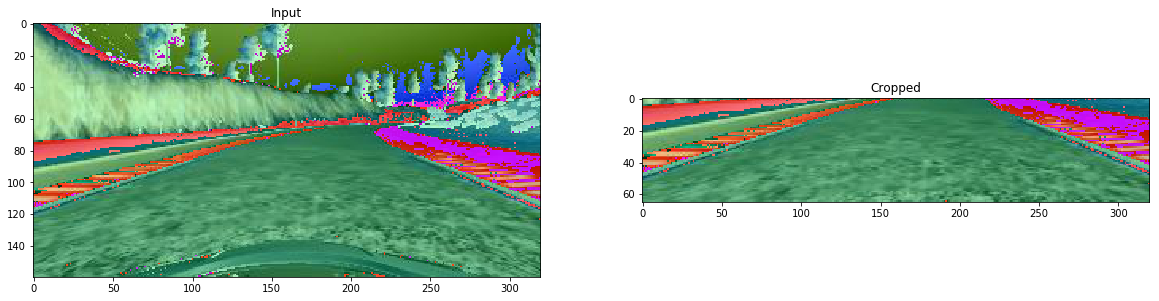

In [123]:
from keras import backend as K

testImages = next(train_generator)[0]
outputLayers = K.function([model.layers[0].input], [model.layers[i].output for i in range(len(model.layers))])([testImages])[0]

# Output of cropping layer
croppingOutput = [outputLayers[0]]
plotImages(images=[testImages[0]] + croppingOutput, titles=['Input', 'Cropped'], columns=2)